# Task 2 (PyTorch): STL-10 CNN + Dataset Content + Test Accuracy

This notebook satisfies **Task 2** in the assignment PDF:

**Objective**
1. Load STL-10 (labelled train/test)  
2. Show dataset content (classes, shapes, sample images), focusing on **data types**  
3. Train a CNN based on the **given CNN code idea** (Conv/Pool stacks → Dense → softmax)  
4. Specify **loss function** + **evaluation metric**  
5. Evaluate and print **test accuracy**

**STL-10 classes**: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.

In [1]:
# ----------------------------
# 0) Imports + Device
# ----------------------------
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("PyTorch:", torch.__version__)

Device: cpu
PyTorch: 2.9.0+cpu


## 1) Load STL-10 (labelled train/test)

In [2]:

import os, time, subprocess, tarfile

def download_and_verify_stl10(url='http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz',
                             out='stl10_binary.tar.gz', max_attempts=5):
    for attempt in range(1, max_attempts + 1):
        print(f'Attempt {attempt}/{max_attempts} -> {out}')
        try:
            # use curl to support resume (-C -) and redirects (-L)
            subprocess.check_call(['curl', '-C', '-', '-L', url, '-o', out])
            # quick verify by opening tar
            with tarfile.open(out, 'r:gz') as tf:
                _ = tf.getmembers()[:1]
            print('Downloaded and verified archive:', out)
            return out
        except (subprocess.CalledProcessError, tarfile.ReadError, EOFError) as e:
            print('Download/verify failed:', repr(e))
            if os.path.exists(out):
                try: os.remove(out)
                except Exception: pass
            if attempt < max_attempts:
                time.sleep(2 * attempt)
    raise RuntimeError('Failed to download and verify STL-10 after retries.')

# call before extraction / dataset loading
archive = download_and_verify_stl10()
print('Extracting...', archive)
with tarfile.open(archive, 'r:gz') as t:
    t.extractall('.')
print('Extraction done. Ensure stl10_binary/ contains train_X.bin')


Attempt 1/5 -> stl10_binary.tar.gz
Downloaded and verified archive: stl10_binary.tar.gz
Extracting... stl10_binary.tar.gz


/tmp/ipython-input-339857509.py:28: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  t.extractall('.')


Extraction done. Ensure stl10_binary/ contains train_X.bin


In [3]:
# ----------------------------
# STL-10 dataset facts (from assignment)
# - 10 classes, 96x96 RGB
# - train: 5000 labeled images (10 pre-defined folds)
# - test: 8000 labeled images
# - unlabeled: 100000 images (not used here)
# ----------------------------
import torchvision.transforms as transforms
from torchvision import datasets

CLASS_NAMES = ["airplane","bird","car","cat","deer","dog","horse","monkey","ship","truck"]
NUM_CLASSES = 10
IMAGE_SIZE = 96

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(96, scale=(0.7, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
            hue=0.05
        )
    ], p=0.8),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
])

data_root = "./data_stl10"

train_set = datasets.STL10(root=data_root, split="train", download=True, transform=transform_train)
test_set  = datasets.STL10(root=data_root, split="test",  download=True, transform=transform_test)

print("Train size:", len(train_set))
print("Test size :", len(test_set))
print("Sample (image, label) types:", type(train_set[0][0]), type(train_set[0][1]))
print("Sample image tensor shape:", train_set[0][0].shape, "dtype:", train_set[0][0].dtype)
print("Sample label:", train_set[0][1], "->", CLASS_NAMES[train_set[0][1]])

100%|██████████| 2.64G/2.64G [02:34<00:00, 17.1MB/s]


Train size: 5000
Test size : 8000
Sample (image, label) types: <class 'torch.Tensor'> <class 'int'>
Sample image tensor shape: torch.Size([3, 96, 96]) dtype: torch.float32
Sample label: 1 -> bird


## 2) Show dataset content (classes, shapes, sample images, data types)

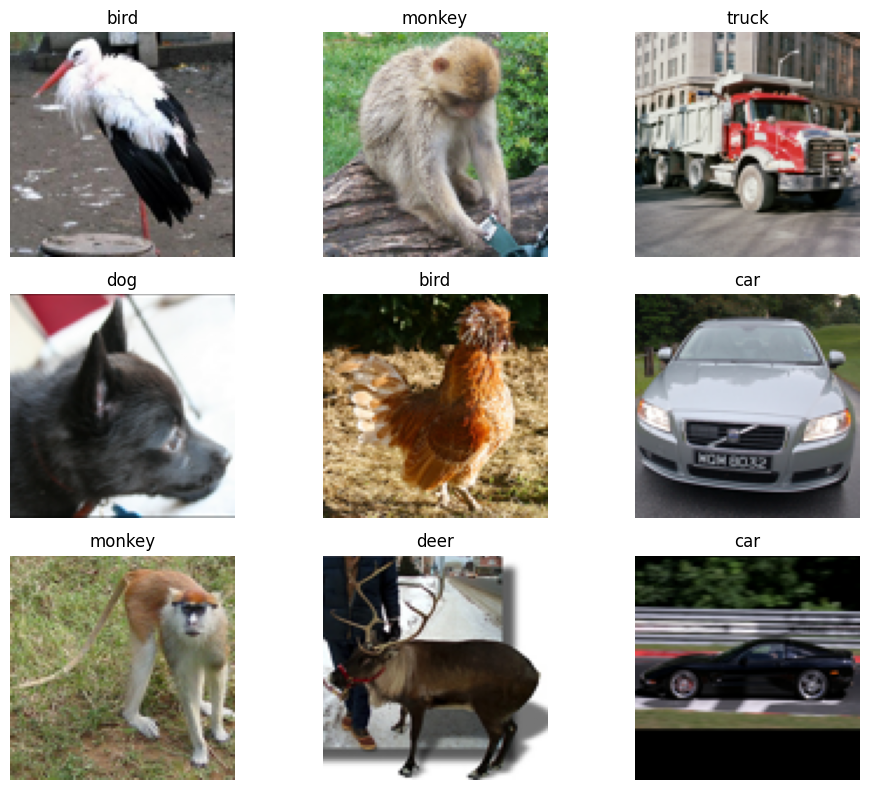

Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Image shape (C,H,W): torch.Size([3, 96, 96]) (= 3 x 96 x 96)
Image dtype: torch.float32
Label dtype: <class 'int'>


In [4]:
# Display a small grid of samples
def denorm(x):
    # undo Normalize(mean=0.5,std=0.5) => back to [0,1]
    return (x * 0.5) + 0.5

fig = plt.figure(figsize=(10, 8))
for i in range(9):
    img, lbl = train_set[random.randint(0, len(train_set)-1)]
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(np.transpose(denorm(img).numpy(), (1,2,0)))
    ax.set_title(CLASS_NAMES[lbl])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Dataset summary table-ish
print("Classes:", CLASS_NAMES)
print("Image shape (C,H,W):", train_set[0][0].shape, "(= 3 x 96 x 96)")
print("Image dtype:", train_set[0][0].dtype)
print("Label dtype:", type(train_set[0][1]))

## 3) DataLoaders

In [5]:
  BATCH_SIZE = 64

  train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
  test_loader  = DataLoader(test_set,  batch_size=128,      shuffle=False, num_workers=2, pin_memory=True)

  # Quick batch check
  Xb, yb = next(iter(train_loader))
  print("Batch X:", Xb.shape, Xb.dtype)
  print("Batch y:", yb.shape, yb.dtype)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch X: torch.Size([64, 3, 96, 96]) torch.float32
Batch y: torch.Size([64]) torch.int64


## 4) CNN Architecture

In [11]:
# Assignment-specified architecture (small variations allowed):
# Input -> Conv3x3 (stride1, 32 maps) -> ReLU -> MaxPool2
# -> Conv3x3 (stride1, 32 maps) -> ReLU -> MaxPool2
# -> Conv3x3 (stride1, 32 maps) -> ReLU -> MaxPool2
# -> Flatten -> FC(64) -> ReLU -> FC(10)

class BasicBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        # <-- CHANGE: use bias=False with BatchNorm for efficiency
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)   # <-- ADDED: BatchNorm for stability
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)

        # <-- CHANGE: projection shortcut when dims change (residual)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_c != out_c:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_c, out_c, 1, stride, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)              # <-- RESIDUAL ADD
        return self.relu(out)


class STL10_ResNetLite(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # <-- CHANGE: stronger initial conv (64 filters)
        self.prep = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # <-- CHANGE: use strided residual blocks to downsample (learned downsampling)
        self.layer1 = BasicBlock(64, 64, stride=1)
        self.layer2 = BasicBlock(64, 128, stride=2)  # 96->48
        self.layer3 = BasicBlock(128, 256, stride=2) # 48->24
        self.layer4 = BasicBlock(256, 256, stride=2) # 24->12

        # <-- CHANGE: global pooling reduces params vs flattening
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=0.4)             # <-- ADDED: stronger dropout
        self.fc   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = (x - 0.5) / 0.5                           # keep normalization in model
        x = self.prep(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

model = STL10_CNN(num_classes=NUM_CLASSES).to(device)
print(model)

# Shape sanity check
with torch.no_grad():
    dummy = torch.zeros(2,3,96,96).to(device)
    out = model(dummy)
    print("Dummy output shape:", out.shape)  # (2,10)

STL10_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4608, out_features=128, bias=Tru

## 5) Loss Function and Evaluation Metric

In [12]:
# Loss:
# - Multi-class classification with integer labels (0..9) -> CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Metric:
# - Accuracy: % correct predictions
def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()

## 6) Train + Evaluate (prints train/test accuracy)

In [ ]:
# ----------------------------
# Hyperparameters (tuned)
# ----------------------------
# EPOCHS = 40                       # <-- CHANGED: increase epochs for better convergence
EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4               # <-- ADDED: weight decay (L2) helps generalization
CLIP_NORM = 1.0                   # <-- ADDED: gradient clipping norm (stabilizes training)

# ----------------------------
# Optimizer + Scheduler (changed)
# ----------------------------
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# <-- CHANGED: AdamW instead of Adam, includes decoupled weight decay

# Scheduler: cosine annealing is a good default for image tasks
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
# <-- ADDED: learning rate scheduler to improve final performance

# ----------------------------
# Mixed precision (optional, GPU only)
# ----------------------------
use_amp = (device.type == "cuda")   # <-- ADDED: enable AMP only when CUDA is available
scaler = torch.cuda.amp.GradScaler() if use_amp else None

# ----------------------------
# Training / evaluation loop (modified)
# ----------------------------
def run_epoch(loader, training: bool):
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_seen = 0

    # <-- CHANGED: use torch.no_grad() during evaluation to save memory and compute
    context = torch.enable_grad() if training else torch.no_grad()
    with context:
        for X, y in loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            if training:
                optimizer.zero_grad(set_to_none=True)

            # <-- CHANGED: use mixed precision autocast when available
            if use_amp and training:
                with torch.cuda.amp.autocast():
                    logits = model(X)
                    loss = criterion(logits, y)
                # scale gradients and step
                scaler.scale(loss).backward()
                # <-- ADDED: gradient clipping (unscale first)
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
                scaler.step(optimizer)
                scaler.update()
            elif use_amp and not training:
                with torch.cuda.amp.autocast():
                    logits = model(X)
                    loss = criterion(logits, y)
            else:
                # no AMP
                logits = model(X)
                loss = criterion(logits, y)
                if training:
                    loss.backward()
                    # <-- ADDED: gradient clipping for non-AMP path
                    torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
                    optimizer.step()

            total_loss += loss.item() * X.size(0)
            total_correct += (logits.argmax(1) == y).sum().item()
            total_seen += X.size(0)

    avg_loss = total_loss / total_seen
    acc = total_correct / total_seen
    return avg_loss, acc

# ----------------------------
# Training loop with scheduler step and checkpointing
# ----------------------------
history = []
best_val_acc = 0.0
start = time.time()

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, training=True)
    te_loss, te_acc = run_epoch(test_loader,  training=False)

    # <-- CHANGED: step scheduler once per epoch (after validation is common)
    scheduler.step()

    history.append((tr_loss, tr_acc, te_loss, te_acc))

    # <-- ADDED: save best model checkpoint by validation accuracy
    if te_acc > best_val_acc:
        best_val_acc = te_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'best_model_checkpoint.pth')

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tr_loss:.4f} acc {tr_acc*100:.2f}% | "
          f"test  loss {te_loss:.4f} acc {te_acc*100:.2f}% | "
          f"lr {optimizer.param_groups[0]['lr']:.2e}")

print("Done in", round(time.time()-start, 1), "seconds")
print("Final train accuracy:", f"{history[-1][1]*100:.2f}%")
print("Final test  accuracy:", f"{history[-1][3]*100:.2f}%")
print("Best validation accuracy:", f"{best_val_acc*100:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/20 | train loss 1.7352 acc 33.74% | test  loss 1.4961 acc 44.76% | lr 9.94e-04
Epoch 02/20 | train loss 1.3815 acc 47.84% | test  loss 1.3233 acc 51.38% | lr 9.76e-04
Epoch 03/20 | train loss 1.2175 acc 54.80% | test  loss 1.3336 acc 50.31% | lr 9.46e-04
Epoch 04/20 | train loss 1.0921 acc 60.08% | test  loss 1.1668 acc 56.59% | lr 9.05e-04
Epoch 05/20 | train loss 0.9868 acc 63.64% | test  loss 1.1305 acc 58.24% | lr 8.54e-04
Epoch 06/20 | train loss 0.8918 acc 67.06% | test  loss 1.0788 acc 61.20% | lr 7.94e-04
Epoch 07/20 | train loss 0.7940 acc 71.44% | test  loss 1.1156 acc 60.89% | lr 7.27e-04
Epoch 08/20 | train loss 0.7149 acc 73.90% | test  loss 1.1215 acc 61.22% | lr 6.55e-04
Epoch 09/20 | train loss 0.6081 acc 78.70% | test  loss 1.1030 acc 61.96% | lr 5.78e-04
Epoch 10/20 | train loss 0.5387 acc 80.30% | test  loss 1.1430 acc 62.89% | lr 5.00e-04
Epoch 11/20 | train loss 0.4599 acc 83.60% | test  loss 1.1144 acc 64.49% | lr 4.22e-04
Epoch 12/20 | train loss 0.3918 

## Bonus: What is overfitting and how to prevent it?

**Overfitting** happens when a model learns the training data *too well* (including noise), achieving high **train accuracy** but noticeably lower **test accuracy** (poor generalization).

**Ways to reduce overfitting**
- Data augmentation (random flips/crops/rotations)
- Regularization (L2 weight decay)
- Dropout layers
- Early stopping (stop when validation loss stops improving)
- Reduce model capacity (fewer layers/filters)
- More training data (or use unlabeled data for semi-/self-supervised pretraining)